# How many games are Pro Player playing

This is the data for an article written for a Gwent team, [Team Bandit Gang](https://teambanditgang.com/climbing-pro-ladder-grind-vs-skill/), here we look at the number of games pro players play each season. We'll also have a look if you can grind your way to the top or not.

In [1]:
%load_ext nb_black

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_excel("./output/player_stats.xlsx").drop(columns=["Unnamed: 0"])

<IPython.core.display.Javascript object>

In [3]:
from functools import reduce

bin_size = 200
bins = []

for i in range(0, 2800, bin_size):
    bin_df = (
        df[
            (i < pd.to_numeric(df["rank"]))
            & (pd.to_numeric(df["rank"]) <= i + bin_size)
        ]
        .groupby(["season"])
        .agg(num_matches=pd.NamedAgg("matches", "sum"),)
        .reset_index()
        .rename(
            columns={"num_matches": "Position %04d to %04d" % (i + bin_size, i + 1)}
        )
    )
    bins.append(bin_df)

merged_df = reduce(
    lambda left, right: pd.merge(left, right, on="season", how="inner"), bins
)

melted_df = merged_df.melt(
    id_vars=["season"], var_name="group", value_name="matches_total"
)
melted_df["matches"] = melted_df["matches_total"] / bin_size
melted_df

,season,group,matches_total,matches
0,M2_01 Wolf 2020,Position 0200 to 0001,88400,442.000
1,M2_02 Love 2020,Position 0200 to 0001,91993,459.965
2,M2_03 Bear 2020,Position 0200 to 0001,103503,517.515
3,M2_04 Elf 2020,Position 0200 to 0001,122769,613.845
4,M2_05 Viper 2020,Position 0200 to 0001,97914,489.570
...,...,...,...,...
345,M3_09 Dryad 2021,Position 2800 to 2601,54602,273.010
346,M3_10 Cat 2021,Position 2800 to 2601,47779,238.895
347,M3_11 Mahakam 2021,Position 2800 to 2601,59041,295.205
348,M3_12 Wild Hunt 2021,Position 2800 to 2601,58357,291.785


<IPython.core.display.Javascript object>

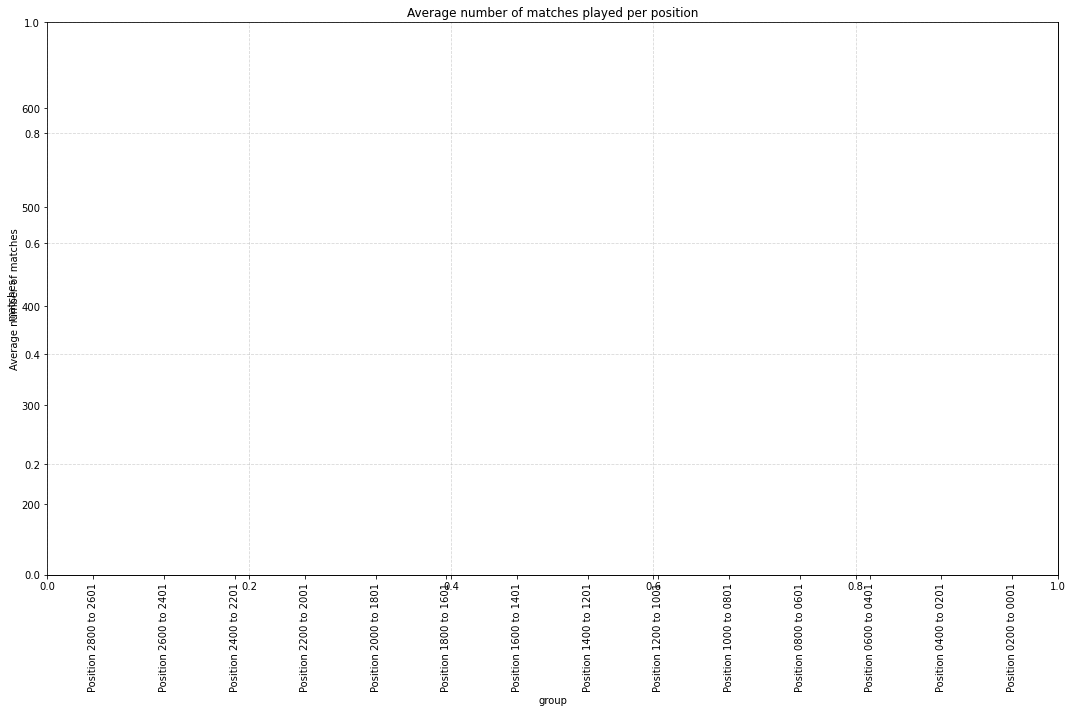

<IPython.core.display.Javascript object>

In [4]:
from matplotlib.ticker import MultipleLocator

ml = MultipleLocator(20)

plt.rcParams["figure.figsize"] = [15, 10]
sns.lineplot(data=melted_df, x="group", y="matches", hue="season").invert_xaxis()
plt.xticks(rotation=90)
plt.axes().yaxis.set_minor_locator(ml)
plt.grid(linestyle="dashed", alpha=0.5, which="both")
plt.title("Average number of matches played per position")
plt.xlabel("")
plt.ylabel("Average number of matches")
plt.tight_layout()
plt.savefig("./images/avg_matches_per_player.png")
plt.savefig("./images/avg_matches_per_player.svg")
plt.show()

So clearly to get in the higher ranks you have to play more games. This echoes something I've heard multiple Pro Players say in their streams; that the current ladder system rewards the quantity over efficiency. For individual players it also gives an impression how efficient they were climbing compared to others around them, and if they would theoretically be able to climb further given time to play more games.

I've reached Pro Rank each season since the season of the Viper though during the season of the Viper and Dryad I didn't get enough games in to reach a position on the leader boards. So let's have a look at my personal stats !

  * Season of Magic: Position 1138 after 254 matches
  * Season of the Griffin: Position 1167 after 260 matches
  * Season of the Draconid: Position 1255 after 214 matches

So during the Season of Magic I landed smack on the line indicating that was probably as good as it would get that season. Though during the season of the Griffin the number of games I played was a hundered games below the average number of games played by others reaching a similar position on the ladder. Similarly, during the Season of the Draconid with 214 matches played, to get into the 1400 - 1200 bin this is about 50 games played less than others in the same bin. 

In [5]:
ridgeline_df = df[df.season == "M3_10 Cat 2021"]


def parse_rank(rank):
    i = (rank - 1) // 200
    return "Position %04d to %04d" % ((i + 1) * 200, i * 200 + 1)


ridgeline_df["group"] = ridgeline_df["rank"].apply(parse_rank)
ridgeline_df = ridgeline_df[ridgeline_df["group"] != "Position 3000 to 2801"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>

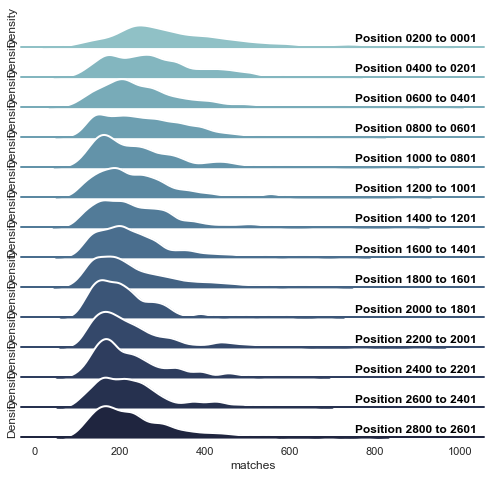

<IPython.core.display.Javascript object>

In [6]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(14, rot=-0.25, light=0.7)
g = sns.FacetGrid(
    ridgeline_df, row="group", hue="group", aspect=15, height=0.5, palette=pal
)

# Draw the densities in a few steps
g.map(
    sns.kdeplot,
    "matches",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5,
)
g.map(sns.kdeplot, "matches", clip_on=False, color="w", lw=2, bw_adjust=0.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0.72,
        0.2,
        label,
        fontweight="bold",
        color="black",
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map(label, "matches")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.savefig("./images/ridgeplot.png")
plt.savefig("./images/ridgeplot.svg")
plt.show()

## Efficiency in different groups

Similarly we can look at the average efficiency (essentially the amount of MMR gained for each match played) in different bins. This is more distorted as players that were not in the top 500 the previous season have to climb back to Pro Rank, games which do no yield you any MMR in Pro Ladder. Though the trends should still hold  

In [7]:
from functools import reduce

bin_size = 200
bins = []

for i in range(0, 2800, bin_size):
    bin_df = (
        df[
            (i < pd.to_numeric(df["rank"]))
            & (pd.to_numeric(df["rank"]) <= i + bin_size)
            # & (df["previous_top500"] == "yes")
            & (df["mmr"] >= 9600)
        ]
        .groupby(["season"])
        .agg(mean_efficiency=pd.NamedAgg("efficiency", "mean"),)
        .reset_index()
        .rename(
            columns={"mean_efficiency": "Position %04d to %04d" % (i + bin_size, i + 1)}
        )
    )
    bins.append(bin_df)

merged_df = reduce(
    lambda left, right: pd.merge(left, right, on="season", how="outer"), bins
)

melted_df = merged_df.melt(
    id_vars=["season"], var_name="group", value_name="mean_efficiency"
).fillna(0)

melted_df

,season,group,mean_efficiency
0,M2_01 Wolf 2020,Position 0200 to 0001,1.091091
1,M2_02 Love 2020,Position 0200 to 0001,1.214749
2,M2_03 Bear 2020,Position 0200 to 0001,1.235145
3,M2_04 Elf 2020,Position 0200 to 0001,1.154645
4,M2_05 Viper 2020,Position 0200 to 0001,1.350191
...,...,...,...
345,M3_09 Dryad 2021,Position 2800 to 2601,0.423185
346,M3_10 Cat 2021,Position 2800 to 2601,0.097331
347,M3_11 Mahakam 2021,Position 2800 to 2601,0.537774
348,M3_12 Wild Hunt 2021,Position 2800 to 2601,0.582473


<IPython.core.display.Javascript object>

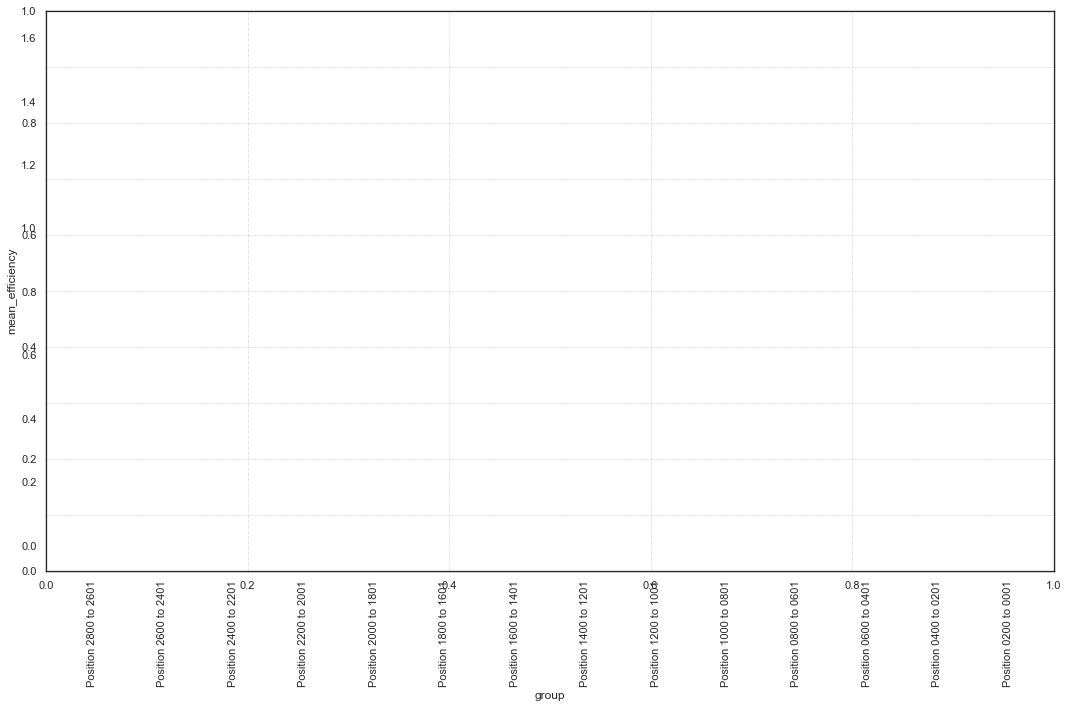

<IPython.core.display.Javascript object>

In [8]:
from matplotlib.ticker import MultipleLocator

ml = MultipleLocator(0.1)
sns.set_theme(style="white")
plt.rcParams["figure.figsize"] = [15, 10]
sns.lineplot(
    data=melted_df, x="group", y="mean_efficiency", hue="season"
).invert_xaxis()
plt.xticks(rotation=90)
plt.axes().yaxis.set_minor_locator(ml)
plt.grid(linestyle="dashed", alpha=0.5, which="both")
plt.tight_layout()
plt.savefig("./images/avg_efficiency.png")
plt.savefig("./images/avg_efficiency.svg")
plt.show()

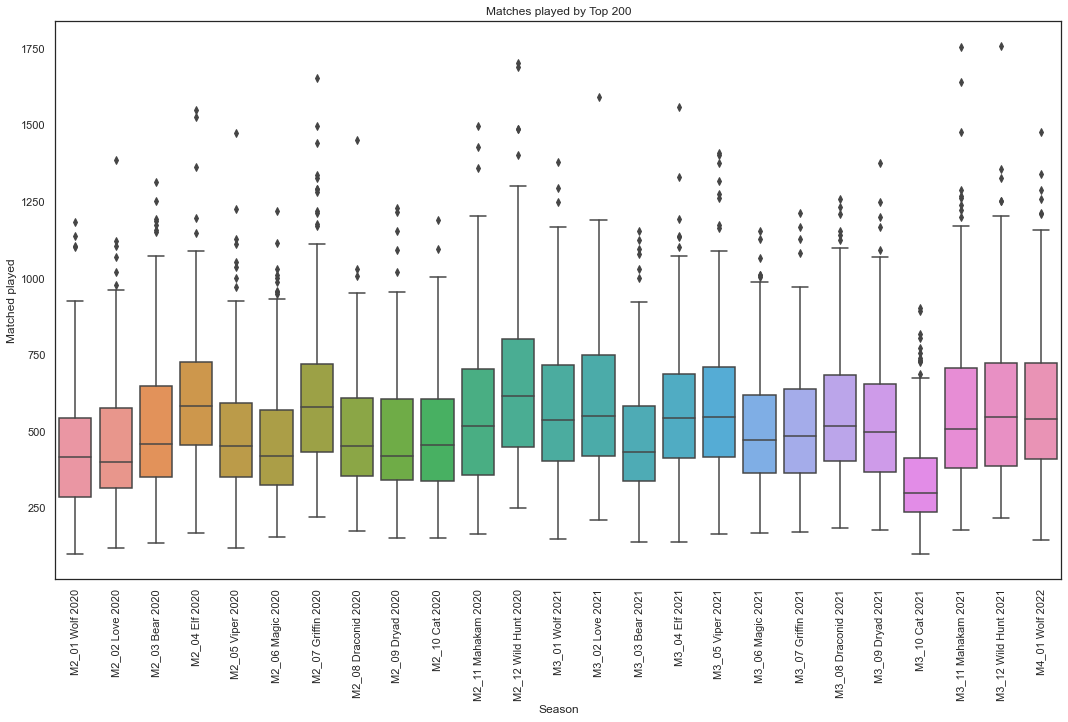

<IPython.core.display.Javascript object>

In [9]:
matches_boxplot_df = df[pd.to_numeric(df["rank"]) <= 200]
sns.boxplot(data=matches_boxplot_df, x="season", y="matches")
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("Matches played by Top 200")
plt.xlabel("Season")
plt.ylabel("Matched played")
plt.savefig("./images/top200_games_boxplot.png")
plt.savefig("./images/top200_games_boxplot.svg")
plt.show()

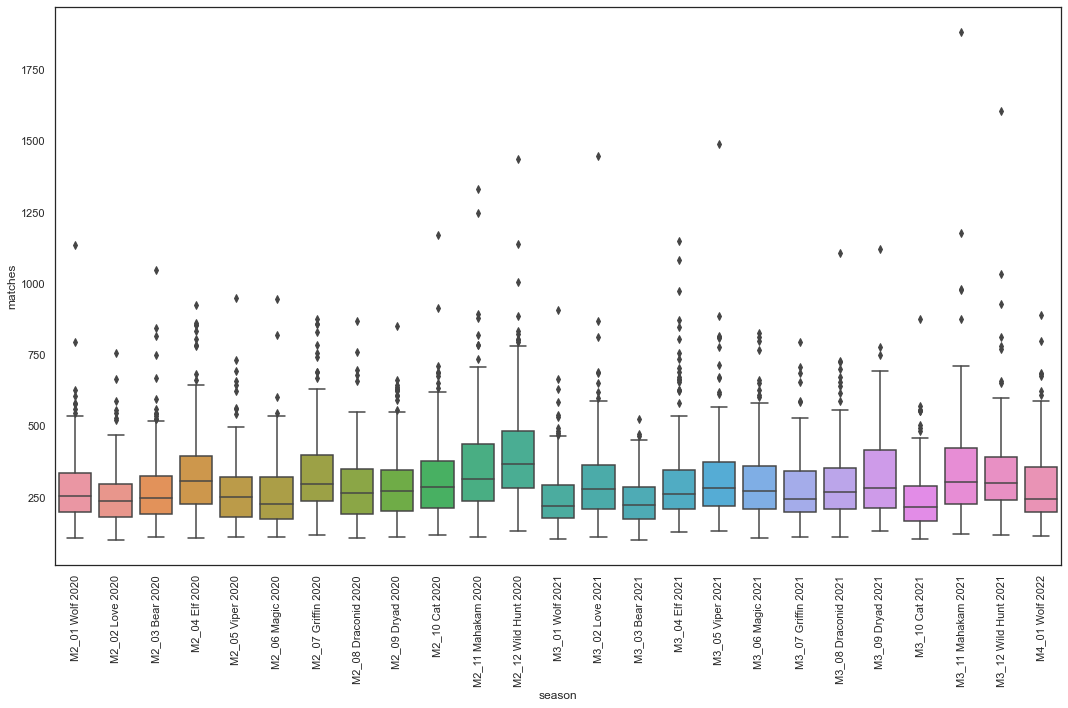

<IPython.core.display.Javascript object>

In [10]:
matches_boxplot_df = df[
    (pd.to_numeric(df["rank"]) > 1000) & (pd.to_numeric(df["rank"]) <= 1200)
]
sns.boxplot(data=matches_boxplot_df, x="season", y="matches")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("./images/top1200-1000_games_boxplot.png")
plt.show()